In [1]:
import os
import sys

import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import plotly.graph_objects as go

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from utils.plotters import visualize_geometry, colorplot, visualize_signal, compare_geometries
from utils.geometries import trigonal_plane, tetrahedron, octahedron, icosahedron, dodecahedron
from utils.alignment import sample_uniform_quaternion, align_signals, find_best_random_quaternion, rotate_points_quaternion, stack_points, point_distance, spherical_harmonic_distance, stack_points, choose_best_quaternion, evenly_distributed_quaternions, quaternion_rotation_distance, spherical_grid_distance
import spectra
from spectra import sum_of_diracs, powerspectrum, bispectrum, trispectrum, invert, reconstruct_geometry


import numpy as np

# Define unit basis vectors
e_x = np.array([1, 0, 0])
e_y = np.array([0, 1, 0])
e_z = np.array([0, 0, 1])

# Geometry A: “xy‐cross”
geom_A = np.vstack([
    +e_x,
    -e_x,
    +e_y,
    -e_y
])

# Geometry B: “xz‐cross”
geom_B = np.vstack([
    +e_x,
    -e_x,
    +e_z,
    -e_z
])

if __name__ == "__main__":
    print("Geometry A (xy‐cross):\n", geom_A)
    print("\nGeometry B (xz‐cross):\n", geom_B)


Geometry A (xy‐cross):
 [[ 1  0  0]
 [-1  0  0]
 [ 0  1  0]
 [ 0 -1  0]]

Geometry B (xz‐cross):
 [[ 1  0  0]
 [-1  0  0]
 [ 0  0  1]
 [ 0  0 -1]]


In [140]:

# Load the structures from the pickle file if it exists
if os.path.exists('../data/boron_structures.pkl'):
    with open('../data/boron_structures.pkl', 'rb') as f:
        local_envs = pickle.load(f)
    print(f"Loaded {len(local_envs)} structures from boron_structures.pkl")
else:
    print("File boron_structures.pkl not found, using structures from previous cell")

Loaded 8000 structures from boron_structures.pkl


In [216]:
import numpy as np

# 1) Define an irregular, chiral tetrahedron (centered at the origin)
# Create an irregular, chiral tetrahedron
geom_A = np.array([
    [0.58, -0.61, -0.64],
    [-0.64, 0.61, -0.69],
    [-0.69, -0.72, 0.64],
    [0.75, 0.72, 0.69]
])


# 2) Make its mirror image (reflect through the y=0 plane)
#    (this flips chirality but preserves all pairwise distances)
mirror_mat = np.diag([1, -1, 1])
geom_B = geom_A @ mirror_mat

geom_A = jnp.array(local_envs[0])
geom_B = jnp.array(local_envs[1])

if __name__ == "__main__":
    print("Geometry A (chiral tetrahedron):\n", geom_A)
    print("\nGeometry B (its mirror image):\n", geom_B)


Geometry A (chiral tetrahedron):
 [[ 1.39454902  0.          0.57793632]
 [-1.23980586  0.63847348  0.57793632]
 [-0.29503787 -1.36298188  0.57793632]
 [-0.91652028  1.05107447 -0.57793632]
 [ 0.33360178 -1.35405938 -0.57793632]
 [ 1.22118593  0.6734032  -0.57793632]
 [ 0.          0.          1.76852686]]

Geometry B (its mirror image):
 [[ 1.39454902  0.          0.57793632]
 [-1.23980586  0.63847348  0.57793632]
 [-0.29503787 -1.36298188  0.57793632]
 [-0.91652028  1.05107447 -0.57793632]
 [ 0.33360178 -1.35405938 -0.57793632]
 [ 1.22118593  0.6734032  -0.57793632]
 [ 0.          0.         -1.76852686]]


/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_67770/3704470614.py:244: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Figure saved as bispectrum_difference.pdf


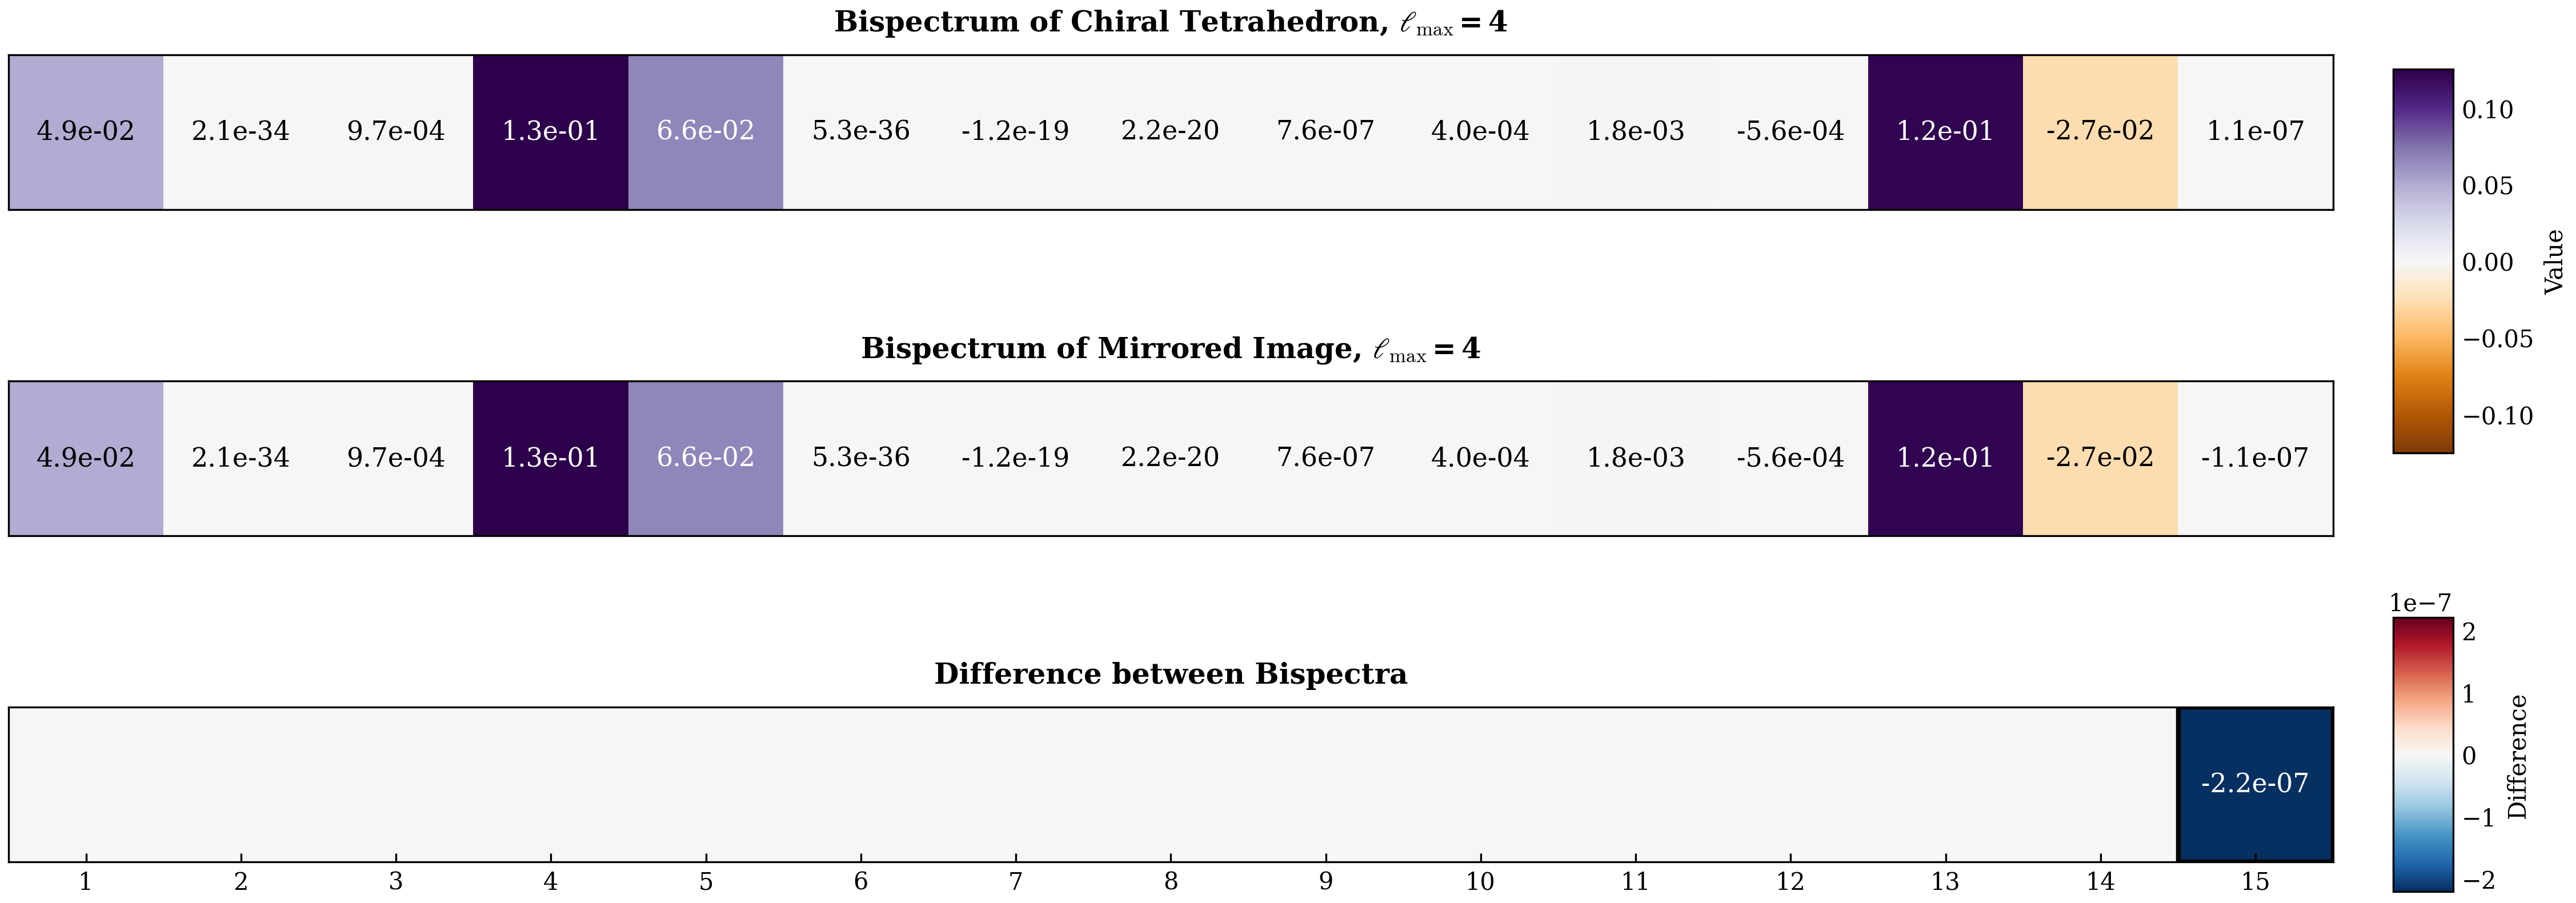

In [ ]:
def colorplot_two_spectra(
    arr1: jnp.ndarray, 
    arr2: jnp.ndarray = None, 
    highlight_diff=True, 
    diff_threshold=0.1, 
    show_values=True, 
    value_precision=1, 
    labels=None, 
    title=None,
    data_cmap="PuOr",
    diff_cmap="RdBu_r",
    cell_size=1.0,
    zero_tolerance=1e-9,
    save_pdf=None,
    dpi=300
):
    """
    Plot two spectra arrays and their difference in a publication-ready format with square cells.
    
    Parameters:
    -----------
    arr1 : jnp.ndarray
        First array to plot
    arr2 : jnp.ndarray, optional
        Second array to plot. If None, only the first array is plotted.
    highlight_diff : bool, optional
        Whether to highlight differences between arrays
    diff_threshold : float, optional
        Threshold for highlighting differences (as fraction of the max value)
    show_values : bool, optional
        Whether to show numerical values in cells
    value_precision : int, optional
        Number of significant digits for the displayed values
    labels : list, optional
        Labels for the arrays and difference
    title : str, optional
        Title for the figure
    data_cmap : str, optional
        Colormap for the original arrays
    diff_cmap : str, optional
        Colormap for the difference plot
    cell_size : float, optional
        Size of each cell in inches (to ensure square cells)
    zero_tolerance : float, optional
        Values smaller than this (in absolute value) are considered zero
    save_pdf : str, optional
        If provided, saves the figure to this file path (e.g., 'figure.pdf')
    dpi : int, optional
        Resolution for saving the figure (dots per inch)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Set default labels
    if labels is None:
        if arr2 is not None:
            labels = ['Array 1', 'Array 2', 'Difference']
        else:
            labels = ['Array 1']
    
    # Ensure arrays are flattened
    arr1_flat = arr1.flatten()
    arr2_flat = None if arr2 is None else arr2.flatten()
    
    # Determine layout
    if arr2 is not None and highlight_diff:
        n_rows = 3
    elif arr2 is not None:
        n_rows = 2
    else:
        n_rows = 1
    
    # Calculate figure size based on number of elements and cell size
    n_elements = len(arr1_flat)
    # Ensure the figure is not too small, with minimum width of 8 inches
    fig_width = max(n_elements * cell_size + 2.5, 8)  # Add 2.5 inches for margins and colorbar
    # Set row height based on cell size (with minimum 1.5 inches per row)
    row_height = max(1.5, cell_size + 0.8)  # Add 0.8 inches for labels and spacing
    fig_height = n_rows * row_height + 1  # Add 1 inch for title and margins
    
    # Create figure
    fig, axes = plt.subplots(n_rows, 1, figsize=(fig_width, fig_height), 
                             gridspec_kw={'hspace': 0.7})
    
    # Convert to list if only one subplot
    if n_rows == 1:
        axes = [axes]
    
    # Set style for publication quality
    plt.rcParams.update({
        'text.usetex': False,  # Don't use LaTeX for text rendering
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
        'mathtext.fontset': 'cm',  # Still use Computer Modern for math
        'axes.titlesize': 12,
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.6,
        'lines.linewidth': 1.5,
        'lines.markersize': 5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 3.5,
        'ytick.major.size': 3.5,
        'xtick.minor.size': 2.0,
        'ytick.minor.size': 2.0,
        'axes.axisbelow': True,
        'axes.grid': False,
    })
    
    # Calculate difference
    diff = arr2_flat - arr1_flat
    
    # Calculate global vmin and vmax for consistent colorscale
    all_values = jnp.concatenate([arr1_flat, arr2_flat])
    vmax = jnp.maximum(jnp.abs(jnp.min(all_values)), jnp.max(all_values))
    vmin = -vmax
    
    # Calculate difference vmax for separate colorscale
    diff_max = jnp.maximum(jnp.abs(jnp.min(diff)), jnp.max(diff))
    diff_vmin, diff_vmax = -diff_max, diff_max
    
    # Plot first array
    im1 = axes[0].imshow(
        arr1_flat.reshape(1, -1), 
        cmap=data_cmap, 
        vmin=vmin, 
        vmax=vmax, 
        aspect='equal'  # Force square cells
    )
    axes[0].set_title(f"{labels[0]}, " + r"$\ell_{\text{max}} = 4$", fontsize=12, pad=10, fontweight='bold')
    axes[0].set_yticks([])
    axes[0].set_xticks([])
    
    # Add values to cells if requested
    if show_values:
        for j in range(len(arr1_flat)):
            value = arr1_flat[j]
            text = f"{value:.{value_precision}e}"
            axes[0].text(j, 0, text, ha="center", va="center", 
                    color="black" if abs(value) < vmax/2 else "white",
                    fontsize=max(9, min(11, int(cell_size * 14))))
    
    # Plot second array
    im2 = axes[1].imshow(
        arr2_flat.reshape(1, -1), 
        cmap=data_cmap, 
        vmin=vmin, 
        vmax=vmax, 
        aspect='equal'  # Force square cells
    )
    axes[1].set_title(f"{labels[1]}, " + r"$\ell_{\text{max}} = 4$", fontsize=12, pad=10, fontweight='bold')
    axes[1].set_yticks([])
    
    # Hide x-tick labels if we're showing the difference
    if highlight_diff:
        axes[1].set_xticks([])
    else:
        # Add column indices at the bottom
        axes[1].set_xticks(range(len(arr2_flat)))
        axes[1].set_xticklabels([str(i+1) for i in range(len(arr2_flat))])
        
    # Add values to cells if requested
    if show_values:
        for j in range(len(arr2_flat)):
            value = arr2_flat[j]
            text = f"{value:.{value_precision}e}"
            axes[1].text(j, 0, text, ha="center", va="center", 
                    color="black" if abs(value) < vmax/2 else "white",
                    fontsize=max(9, min(11, int(cell_size * 14))))
    
    # Calculate colorbar position based on layout
    if highlight_diff:
        # For 3-row layout (with difference plot)
        cbar_ax = fig.add_axes([0.92, 0.5, 0.02, 0.35])  # [left, bottom, width, height]
    else:
        # For 2-row layout (no difference plot) - center the colorbar between the two arrays
        cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjusted position for 2-row layout
        
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.ax.set_ylabel('Value', fontsize=10)
    
    # Plot difference if requested
    if highlight_diff:
        im_diff = axes[2].imshow(
            diff.reshape(1, -1), 
            cmap=diff_cmap,  # Different colormap for differences
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            aspect='equal'  # Force square cells
        )
        axes[2].set_title(f"{labels[2]}", fontsize=12, pad=10, fontweight='bold')
        
        # Add column indices at the bottom
        axes[2].set_xticks(range(len(diff)))
        axes[2].set_xticklabels([str(i+1) for i in range(len(diff))], 
                                rotation=45 if n_elements > 15 else 0)
        axes[2].set_yticks([])
        
        # Add a separate colorbar for the difference
        cbar_diff_ax = fig.add_axes([0.92, 0.1, 0.02, 0.25])  # [left, bottom, width, height]
        cbar_diff = fig.colorbar(im_diff, cax=cbar_diff_ax)
        cbar_diff.ax.set_ylabel('Difference', fontsize=10)
        
        # Add values and highlight significant differences
        if show_values:
            for j in range(len(diff)):
                value = diff[j]
                
                # Skip text for zero values
                if abs(value) < zero_tolerance:
                    continue
                    
                text = f"{value:.{value_precision}e}"
                
                # Add a rectangle around cells with significant differences
                if abs(value) > diff_threshold * diff_max:
                    rect = plt.Rectangle((j-0.5, -0.5), 1, 1, fill=False, 
                                        edgecolor='black', linestyle='-', linewidth=2)
                    axes[2].add_patch(rect)
                    
                axes[2].text(j, 0, text, ha="center", va="center", 
                        color="black" if abs(value) < diff_max/2 else "white",
                        fontsize=max(9, min(11, int(cell_size * 14))))

    
    # Set title if provided
    if title:
        fig.suptitle(f"{title}, " + r"$\ell_{\text{max}} = 4$", fontsize=14, y=0.98, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)  # Make room for the colorbar
    
    # Save as PDF if a filename is provided
    if save_pdf:
        plt.savefig(save_pdf, format='pdf', bbox_inches='tight', dpi=dpi)
        print(f"Figure saved as {save_pdf}")
    
    return fig

a_ps = powerspectrum(sum_of_diracs(geom_A, lmax=4))
b_ps = powerspectrum(sum_of_diracs(geom_B, lmax=4))

a_bs = bispectrum(sum_of_diracs(geom_A, lmax=4))
b_bs = bispectrum(sum_of_diracs(geom_B, lmax=4))

a_ts = trispectrum(sum_of_diracs(geom_A, lmax=2))
b_ts = trispectrum(sum_of_diracs(geom_B, lmax=2))

# _ = colorplot_two_spectra(a_ps, b_ps, labels=['Power Spectrum of Chiral Tetrahedron', 'Power Spectrum of Mirrored Image', 'Difference in Power Spectra'], highlight_diff=False, save_pdf='power_spectrum_difference.pdf', dpi=600)
_ = colorplot_two_spectra(a_bs, b_bs, labels=['Bispectrum of Chiral Tetrahedron', 'Bispectrum of Mirrored Image', 'Difference between Bispectra'], highlight_diff=True, save_pdf='bispectrum_difference.pdf', dpi=600)


# _ = colorplot_two_spectra(a_ps, b_ps, labels=['Power Spectrum of Boron Cluster 1', 'Power Spectrum of Boron Cluster 1', 'Difference'], highlight_diff=False, save_pdf='power_spectrum_difference.pdf', dpi=600)
# _ = colorplot_two_spectra(a_bs, b_bs, labels=['Bispectrum of Boron Cluster (First in Degenerate Pair)', 'Bispectrum of Boron Cluster (Second in Degenerate Pair)', 'Difference between Bispectra'], highlight_diff=False, save_pdf='bispectrum_difference.pdf', dpi=600)
# _ = colorplot_two_spectra(a_ts, b_ts, labels=['Trispectrum of B$_{8}$ Cluster (First in Degenerate Pair)', 'Trispectrum of B$_{8}$ Cluster (Second in Degenerate Pair)', 'Difference between Trispectra'], highlight_diff=True, save_pdf='trispectrum_difference.pdf', dpi=600, diff_cmap="RdBu_r")


In [212]:
def colorplot_two_spectra(
    arr1: jnp.ndarray, 
    arr2: jnp.ndarray = None, 
    highlight_diff=True, 
    diff_threshold=0.1, 
    show_values=True, 
    value_precision=1, 
    labels=None, 
    title=None,
    data_cmap="PuOr",
    diff_cmap="RdBu_r",
    cell_size=1.0,
    zero_tolerance=1e-9,
    save_pdf=None,
    dpi=300,
    reshape_dims=None,  # New parameter to reshape arrays into a matrix
    vertical_spacing=0.2  # New parameter to control vertical spacing
):
    """
    Plot two spectra arrays and their difference in a publication-ready format.
    
    Parameters:
    -----------
    arr1 : jnp.ndarray
        First array to plot
    arr2 : jnp.ndarray, optional
        Second array to plot. If None, only the first array is plotted.
    highlight_diff : bool, optional
        Whether to highlight differences between arrays
    diff_threshold : float, optional
        Threshold for highlighting differences (as fraction of the max value)
    show_values : bool, optional
        Whether to show numerical values in cells
    value_precision : int, optional
        Number of significant digits for the displayed values
    labels : list, optional
        Labels for the arrays and difference
    title : str, optional
        Title for the figure
    data_cmap : str, optional
        Colormap for the original arrays
    diff_cmap : str, optional
        Colormap for the difference plot
    cell_size : float, optional
        Size of each cell in inches (to ensure square cells)
    zero_tolerance : float, optional
        Values smaller than this (in absolute value) are considered zero
    save_pdf : str, optional
        If provided, saves the figure to this file path (e.g., 'figure.pdf')
    dpi : int, optional
        Resolution for saving the figure (dots per inch)
    reshape_dims : tuple, optional
        If provided, reshape the flat arrays into matrices of this shape (e.g., (3, 5))
    vertical_spacing : float, optional
        Controls the spacing between subplots (smaller values = less spacing)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Set default labels
    if labels is None:
        if arr2 is not None:
            labels = ['Array 1', 'Array 2', 'Difference']
        else:
            labels = ['Array 1']
    
    # Ensure arrays are flattened
    arr1_flat = arr1.flatten()
    arr2_flat = None if arr2 is None else arr2.flatten()
    
    # Reshape arrays if reshape_dims is provided
    if reshape_dims is not None:
        # Check if the dimensions match the number of elements
        if len(arr1_flat) != reshape_dims[0] * reshape_dims[1]:
            raise ValueError(f"Cannot reshape array of length {len(arr1_flat)} to dimensions {reshape_dims}")
        
        arr1_display = arr1_flat.reshape(reshape_dims)
        arr2_display = None if arr2_flat is None else arr2_flat.reshape(reshape_dims)
    else:
        # Use original 1-row layout
        arr1_display = arr1_flat.reshape(1, -1)
        arr2_display = None if arr2_flat is None else arr2_flat.reshape(1, -1)
    
    # Determine layout
    if arr2 is not None and highlight_diff:
        n_rows = 3
    elif arr2 is not None:
        n_rows = 2
    else:
        n_rows = 1
    
    # Calculate figure size based on dimensions and cell size - MORE COMPACT HEIGHT
    if reshape_dims is not None:
        n_cols, n_rows_per_plot = reshape_dims[1], reshape_dims[0]
        # Adjust width for the reshaped layout
        fig_width = max(n_cols * cell_size + 2.5, 8)  # Add 2.5 inches for margins and colorbar
        # Height depends on number of rows in each plot and number of plots - MORE COMPACT
        plot_height = n_rows_per_plot * cell_size + 0.6  # Reduced from 1.0 to 0.6
        fig_height = n_rows * plot_height + 0.5  # Reduced from 1.0 to 0.5
    else:
        n_elements = len(arr1_flat)
        fig_width = max(n_elements * cell_size + 2.5, 8)
        row_height = max(1.2, cell_size + 0.6)  # Reduced from 1.5/0.8 to 1.2/0.6
        fig_height = n_rows * row_height + 0.5  # Reduced from 1.0 to 0.5
    
    # Create figure with REDUCED vertical spacing
    fig, axes = plt.subplots(n_rows, 1, figsize=(fig_width, fig_height), 
                             gridspec_kw={'hspace': vertical_spacing})  # Reduced from 0.7 to customizable value
    
    # Convert to list if only one subplot
    if n_rows == 1:
        axes = [axes]
    
    # Set style for publication quality
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.serif': ['Computer Modern Roman', 'DejaVu Serif', 'Times New Roman'],
        'mathtext.fontset': 'cm',
        'axes.titlesize': 11,  # Reduced from 12 to 11
        'axes.labelsize': 10,  # Reduced from 11 to 10
        'xtick.labelsize': 9,  # Reduced from 10 to 9
        'ytick.labelsize': 9,  # Reduced from 10 to 9
        'legend.fontsize': 9,   # Reduced from 10 to 9
        'figure.dpi': 300,
        'savefig.dpi': 600,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.6,
        'lines.linewidth': 1.5,
        'lines.markersize': 5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 3.0,  # Reduced from 3.5 to 3.0
        'ytick.major.size': 3.0,  # Reduced from 3.5 to 3.0
        'xtick.minor.size': 1.5,  # Reduced from 2.0 to 1.5
        'ytick.minor.size': 1.5,  # Reduced from 2.0 to 1.5
        'axes.axisbelow': True,
        'axes.grid': False,
    })
    
    # Calculate difference
    diff = None if arr2_flat is None else arr2_flat - arr1_flat
    if diff is not None and reshape_dims is not None:
        diff_display = diff.reshape(reshape_dims)
    elif diff is not None:
        diff_display = diff.reshape(1, -1)
    
    # Calculate global vmin and vmax for consistent colorscale
    if arr2_flat is not None:
        all_values = jnp.concatenate([arr1_flat, arr2_flat])
    else:
        all_values = arr1_flat
    vmax = jnp.maximum(jnp.abs(jnp.min(all_values)), jnp.max(all_values))
    vmin = -vmax
    
    # Calculate difference vmax for separate colorscale if needed
    if diff is not None:
        diff_max = jnp.maximum(jnp.abs(jnp.min(diff)), jnp.max(diff))
        diff_vmin, diff_vmax = -diff_max, diff_max
    
    # Plot first array
    im1 = axes[0].imshow(
        arr1_display, 
        cmap=data_cmap, 
        vmin=vmin, 
        vmax=vmax, 
        aspect='equal'  # Force square cells
    )
    # REDUCED title padding
    axes[0].set_title(f"{labels[0]}, " + r"$\ell_{\text{max}} = 4$", fontsize=11, pad=5, fontweight='bold')
    
    # Set tick marks for 2D layout
    if reshape_dims is not None:
        axes[0].set_xticks(range(reshape_dims[1]))
        axes[0].set_yticks(range(reshape_dims[0]))
        # Make the tick labels start from 1 instead of 0
        axes[0].set_xticklabels([str(i+1) for i in range(reshape_dims[1])])
        axes[0].set_yticklabels([str(i+1) for i in range(reshape_dims[0])])
    else:
        axes[0].set_yticks([])
        axes[0].set_xticks([])
    
    # Add values to cells if requested
    if show_values:
        if reshape_dims is not None:
            for i in range(reshape_dims[0]):
                for j in range(reshape_dims[1]):
                    value = arr1_display[i, j]
                    if abs(value) < zero_tolerance:
                        continue
                    text = f"{value:.{value_precision}e}"
                    axes[0].text(j, i, text, ha="center", va="center", 
                            color="black" if abs(value) < vmax/2 else "white",
                            fontsize=max(7, min(9, int(cell_size * 10))))  # Smaller font size
        else:
            for j in range(len(arr1_flat)):
                value = arr1_flat[j]
                if abs(value) < zero_tolerance:
                    continue
                text = f"{value:.{value_precision}e}"
                axes[0].text(j, 0, text, ha="center", va="center", 
                        color="black" if abs(value) < vmax/2 else "white",
                        fontsize=max(7, min(9, int(cell_size * 10))))  # Smaller font size
    
    # Plot second array if provided
    if arr2_display is not None:
        im2 = axes[1].imshow(
            arr2_display, 
            cmap=data_cmap, 
            vmin=vmin, 
            vmax=vmax, 
            aspect='equal'  # Force square cells
        )
        # REDUCED title padding
        axes[1].set_title(f"{labels[1]}, " + r"$\ell_{\text{max}} = 4$", fontsize=11, pad=5, fontweight='bold')
        
        # Set tick marks for 2D layout
        if reshape_dims is not None:
            axes[1].set_xticks(range(reshape_dims[1]))
            axes[1].set_yticks(range(reshape_dims[0]))
            # Make the tick labels start from 1 instead of 0
            axes[1].set_xticklabels([str(i+1) for i in range(reshape_dims[1])])
            axes[1].set_yticklabels([str(i+1) for i in range(reshape_dims[0])])
        else:
            axes[1].set_yticks([])
            # Hide x-tick labels if we're showing the difference
            if highlight_diff:
                axes[1].set_xticks([])
            else:
                # Add column indices at the bottom
                axes[1].set_xticks(range(len(arr2_flat)))
                axes[1].set_xticklabels([str(i+1) for i in range(len(arr2_flat))])
        
        # Add values to cells if requested
        if show_values:
            if reshape_dims is not None:
                for i in range(reshape_dims[0]):
                    for j in range(reshape_dims[1]):
                        value = arr2_display[i, j]
                        if abs(value) < zero_tolerance:
                            continue
                        text = f"{value:.{value_precision}e}"
                        axes[1].text(j, i, text, ha="center", va="center", 
                                color="black" if abs(value) < vmax/2 else "white",
                                fontsize=max(7, min(9, int(cell_size * 10))))  # Smaller font size
            else:
                for j in range(len(arr2_flat)):
                    value = arr2_flat[j]
                    if abs(value) < zero_tolerance:
                        continue
                    text = f"{value:.{value_precision}e}"
                    axes[1].text(j, 0, text, ha="center", va="center", 
                            color="black" if abs(value) < vmax/2 else "white",
                            fontsize=max(7, min(9, int(cell_size * 10))))  # Smaller font size
    
    # Calculate colorbar position based on layout
    if arr2_display is not None and highlight_diff:
        # For 3-row layout (with difference plot) - MORE COMPACT
        cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # Adjusted to be more compact
    elif arr2_display is not None:
        # For 2-row layout (no difference plot) - MORE COMPACT
        cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjusted to be more compact
    else:
        # For 1-row layout (only first array) - MORE COMPACT
        cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjusted to be more compact
        
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.ax.set_ylabel('Value', fontsize=9)  # Reduced from 10 to 9
    
    # Plot difference if requested and second array is provided
    if highlight_diff and diff_display is not None:
        im_diff = axes[2].imshow(
            diff_display, 
            cmap=diff_cmap,  # Different colormap for differences
            vmin=diff_vmin, 
            vmax=diff_vmax, 
            aspect='equal'  # Force square cells
        )
        # REDUCED title padding
        axes[2].set_title(f"{labels[2]}", fontsize=11, pad=5, fontweight='bold')
        
        # Set tick marks for 2D layout
        if reshape_dims is not None:
            axes[2].set_xticks(range(reshape_dims[1]))
            axes[2].set_yticks(range(reshape_dims[0]))
            # Make the tick labels start from 1 instead of 0
            axes[2].set_xticklabels([str(i+1) for i in range(reshape_dims[1])])
            axes[2].set_yticklabels([str(i+1) for i in range(reshape_dims[0])])
        else:
            # Add column indices at the bottom
            axes[2].set_xticks(range(len(diff)))
            axes[2].set_xticklabels([str(i+1) for i in range(len(diff))], 
                                    rotation=45 if len(diff) > 15 else 0)
            axes[2].set_yticks([])
        
        # Add a separate colorbar for the difference - MORE COMPACT
        cbar_diff_ax = fig.add_axes([0.92, 0.15, 0.02, 0.25])  # Adjusted to be more compact
        cbar_diff = fig.colorbar(im_diff, cax=cbar_diff_ax)
        cbar_diff.ax.set_ylabel('Difference', fontsize=9)  # Reduced from 10 to 9
        
        # Add values and highlight significant differences
        if show_values:
            if reshape_dims is not None:
                for i in range(reshape_dims[0]):
                    for j in range(reshape_dims[1]):
                        value = diff_display[i, j]
                        
                        # Skip text for zero values
                        if abs(value) < zero_tolerance:
                            continue
                            
                        text = f"{value:.{value_precision}e}"
                        
                        # Add a rectangle around cells with significant differences
                        if abs(value) > diff_threshold * diff_max:
                            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, 
                                                edgecolor='black', linestyle='-', linewidth=1.5)  # Reduced from 2 to 1.5
                            axes[2].add_patch(rect)
                            
                        axes[2].text(j, i, text, ha="center", va="center", 
                                color="black" if abs(value) < diff_max/2 else "white",
                                fontsize=max(7, min(9, int(cell_size * 10))))  # Smaller font size
            else:
                for j in range(len(diff)):
                    value = diff[j]
                    
                    # Skip text for zero values
                    if abs(value) < zero_tolerance:
                        continue
                        
                    text = f"{value:.{value_precision}e}"
                    
                    # Add a rectangle around cells with significant differences
                    if abs(value) > diff_threshold * diff_max:
                        rect = plt.Rectangle((j-0.5, -0.5), 1, 1, fill=False, 
                                            edgecolor='black', linestyle='-', linewidth=1.5)  # Reduced from 2 to 1.5
                        axes[2].add_patch(rect)
                        
                    axes[2].text(j, 0, text, ha="center", va="center", 
                            color="black" if abs(value) < diff_max/2 else "white",
                            fontsize=max(7, min(9, int(cell_size * 10))))  # Smaller font size
    
    # Set title if provided - REDUCED padding
    if title:
        fig.suptitle(f"{title}, " + r"$\ell_{\text{max}} = 4$", fontsize=12, y=0.99, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)  # Make room for the colorbar
    
    # Save as PDF if a filename is provided
    if save_pdf:
        plt.savefig(save_pdf, format='pdf', bbox_inches='tight', dpi=dpi)
        print(f"Figure saved as {save_pdf}")
    
    return fig

/var/folders/7c/7cx32s8x1x32j9xw0z_x3y980000gn/T/ipykernel_67770/2104818458.py:355: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Figure saved as ../bispectrum_difference.pdf


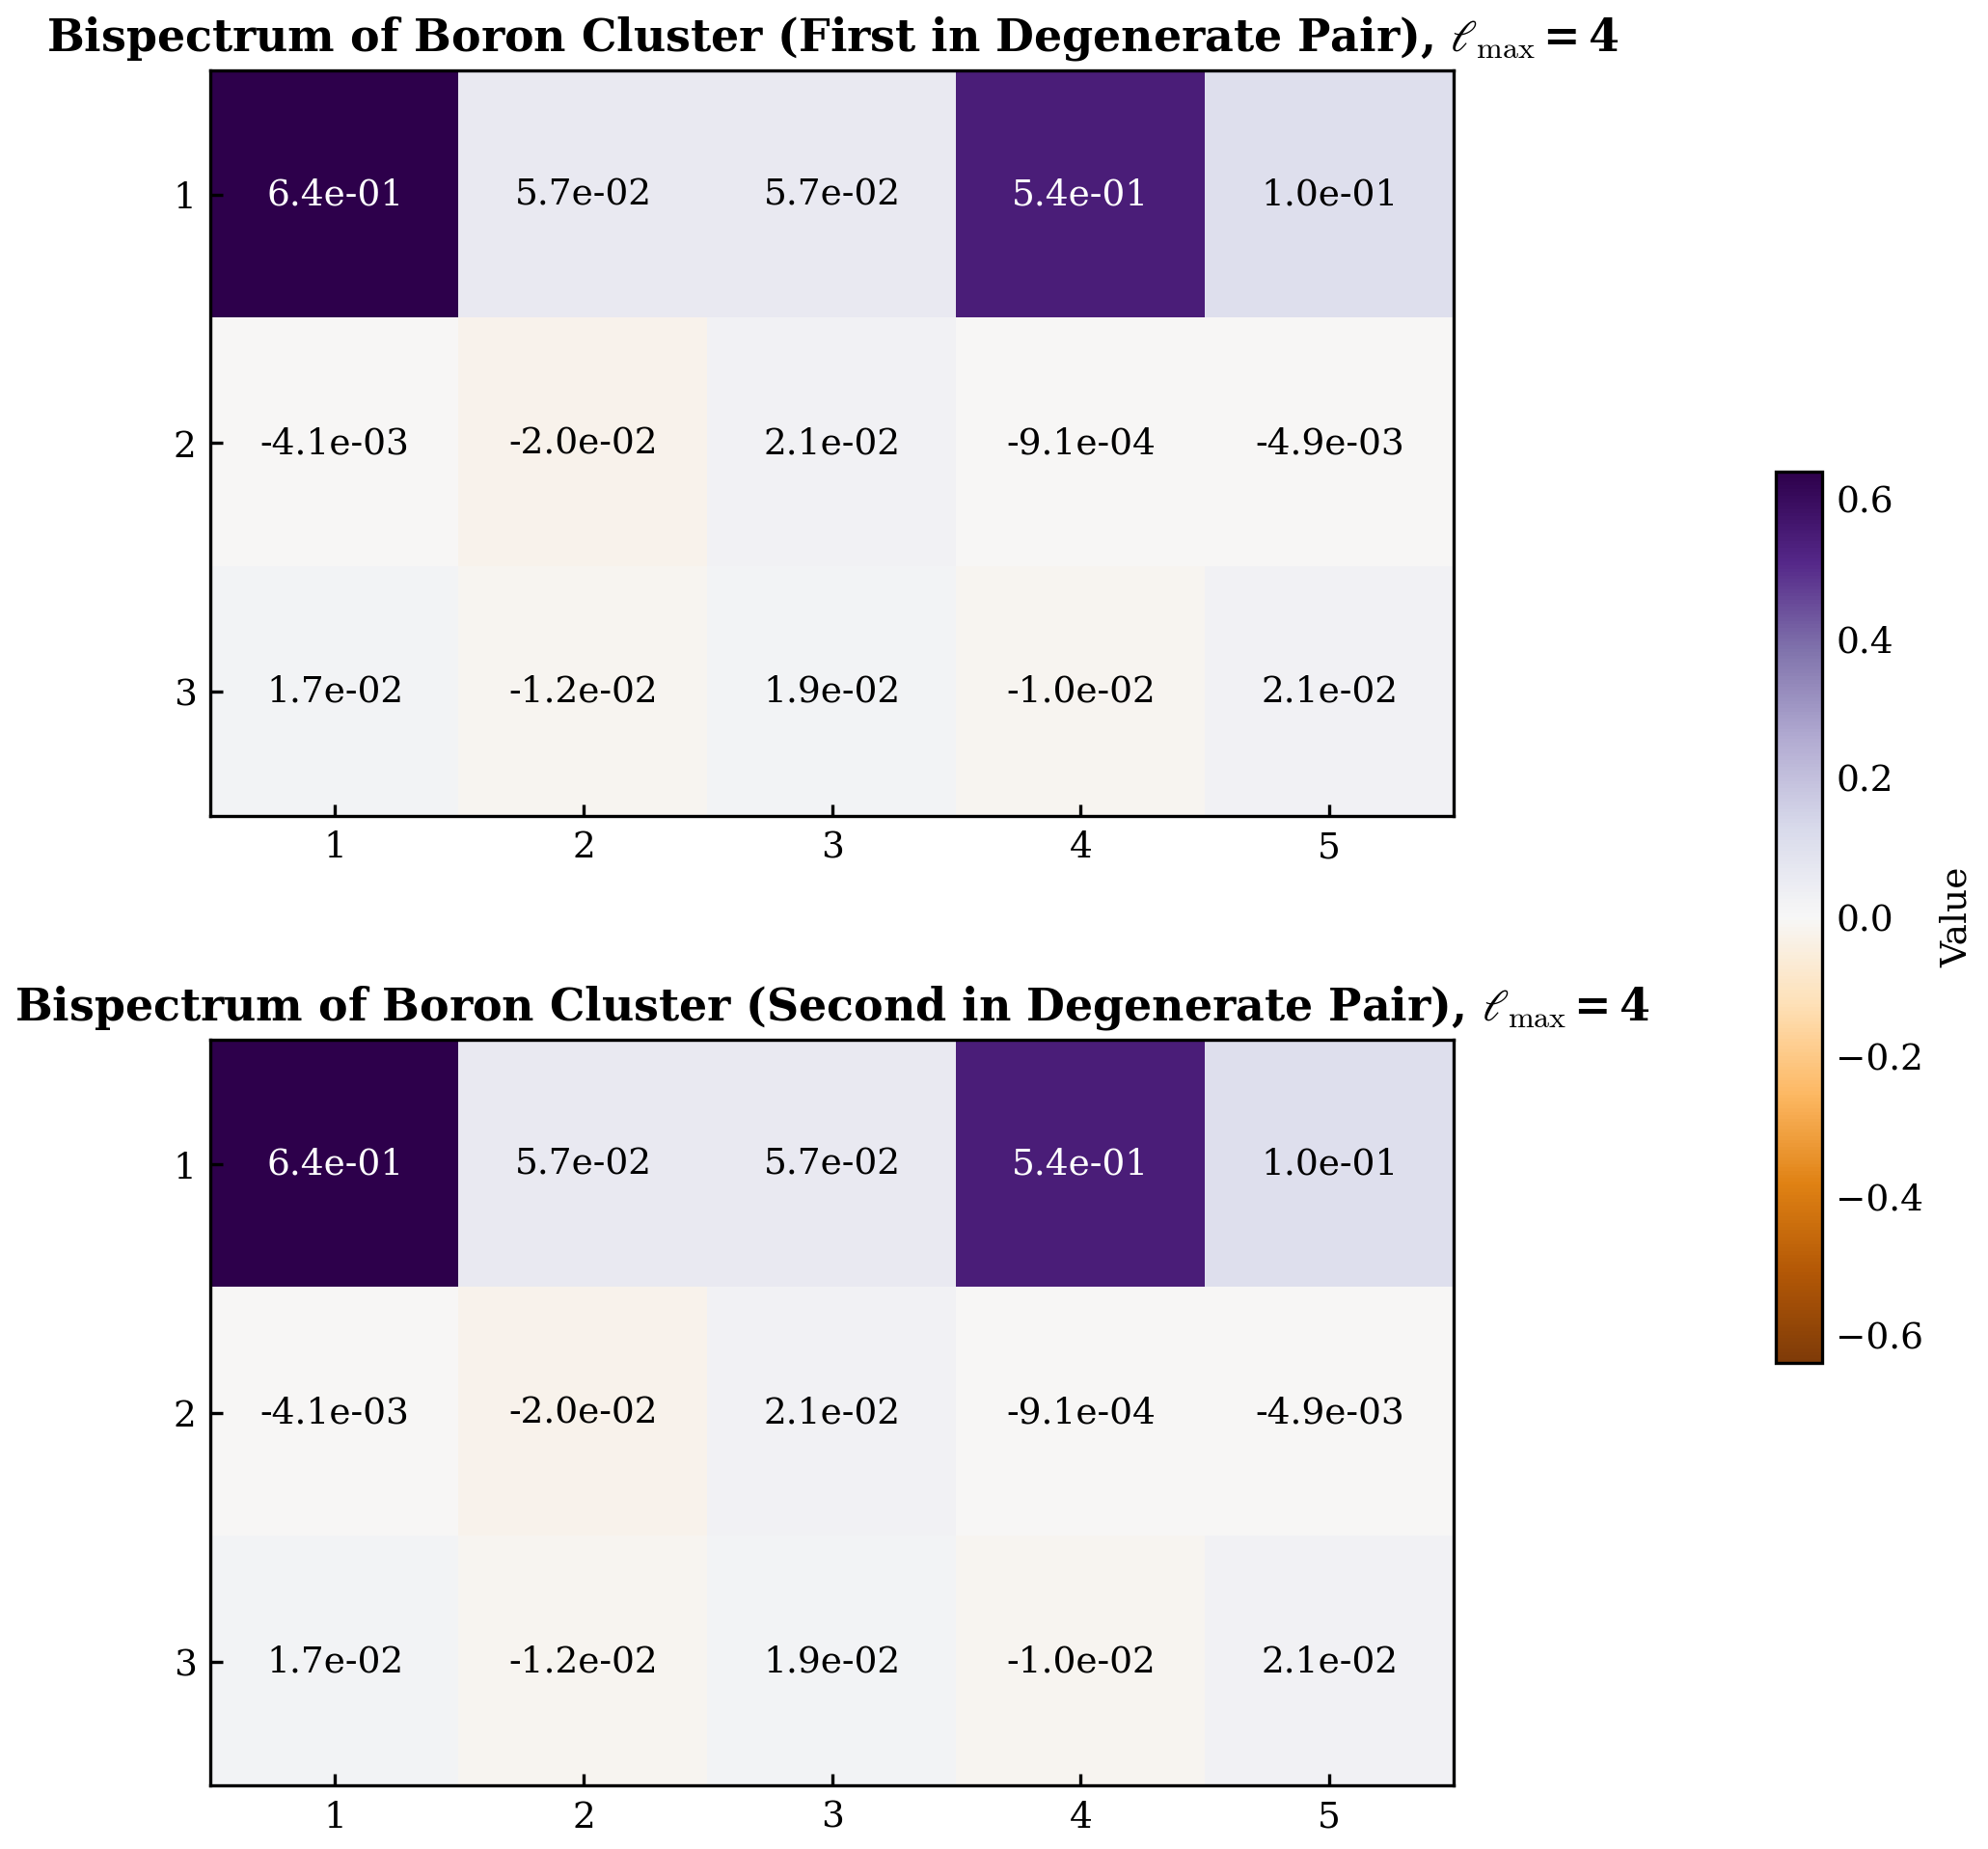

In [218]:
a_ps = powerspectrum(sum_of_diracs(geom_A, lmax=4))
b_ps = powerspectrum(sum_of_diracs(geom_B, lmax=4))

a_bs = bispectrum(sum_of_diracs(geom_A, lmax=4))
b_bs = bispectrum(sum_of_diracs(geom_B, lmax=4))

a_ts = trispectrum(sum_of_diracs(geom_A, lmax=2))
b_ts = trispectrum(sum_of_diracs(geom_B, lmax=2))

# _ = colorplot_two_spectra(a_ps, b_ps, labels=['Power Spectrum of Chiral Tetrahedron', 'Power Spectrum of Mirrored Image', 'Difference in Power Spectra'], highlight_diff=False, save_pdf='power_spectrum_difference.pdf', dpi=600)
# _ = colorplot_two_spectra(a_bs, b_bs, labels=['Bispectrum of Chiral Tetrahedron', 'Bispectrum of Mirrored Image', 'Difference between Bispectra'], highlight_diff=True, save_pdf='../bispectrum_difference.pdf', dpi=600, reshape_dims=(3, 5), vertical_spacing=0.3)


# _ = colorplot_two_spectra(a_ps, b_ps, labels=['Power Spectrum of Boron Cluster 1', 'Power Spectrum of Boron Cluster 1', 'Difference'], highlight_diff=False, save_pdf='power_spectrum_difference.pdf', dpi=600)
_ = colorplot_two_spectra(a_bs, b_bs, labels=['Bispectrum of Boron Cluster (First in Degenerate Pair)', 'Bispectrum of Boron Cluster (Second in Degenerate Pair)', 'Difference between Bispectra'], highlight_diff=False, save_pdf='../bispectrum_difference.pdf', dpi=600, vertical_spacing=0.3, reshape_dims=(3, 5))
# _ = colorplot_two_spectra(a_ts, b_ts, labels=['Trispectrum of B$_{8}$ Cluster (First in Degenerate Pair)', 'Trispectrum of B$_{8}$ Cluster (Second in Degenerate Pair)', 'Difference between Trispectra'], highlight_diff=True, save_pdf='trispectrum_difference.pdf', dpi=600, diff_cmap="RdBu_r")


In [222]:
geom = tetrahedron

b_bs = bispectrum(sum_of_diracs(geom, lmax=4))

In [223]:
print(b_bs[-1])

1.9845380202233175e-20


In [224]:
geom_A = np.array([
    [0.58, -0.61, -0.64],
    [-0.64, 0.61, -0.69],
    [-0.69, -0.72, 0.64],
    [0.75, 0.72, 0.69]
])

In [226]:
tetrahedron

Array([[ 0.5774 , -0.5774 , -0.5774 ],
       [-0.63514,  0.63514, -0.63514],
       [-0.69288, -0.69288,  0.69288],
       [ 0.75062,  0.75062,  0.75062]], dtype=float64)

In [225]:
jnp.linalg.norm(geom_A, axis=1)

Array([1.05740248, 1.12151683, 1.18494726, 1.24779806], dtype=float64)

In [227]:
# Normalize the tetrahedron vertices
# Get the scaling factors from the previous cell
scaling_factors = jnp.array([1.05740248, 1.12151683, 1.18494726, 1.24779806])

# Get the vertices from two cells ago
vertices = jnp.array([
    [0.5774, -0.5774, -0.5774],
    [-0.63514, 0.63514, -0.63514],
    [-0.69288, -0.69288, 0.69288],
    [0.75062, 0.75062, 0.75062]
])

# Multiply each row by its corresponding scaling factor
scaled_vertices = vertices * scaling_factors[:, None]

# Display the result
scaled_vertices


Array([[ 0.61054419, -0.61054419, -0.61054419],
       [-0.7123202 ,  0.7123202 , -0.7123202 ],
       [-0.82102626, -0.82102626,  0.82102626],
       [ 0.93662218,  0.93662218,  0.93662218]], dtype=float64)

In [240]:
# Calculate pairwise angles between vectors in geom_A
def calculate_angles(vectors):
    n = vectors.shape[0]
    angles = []
    
    for i in range(n):
        for j in range(i+1, n):
            # Get the two vectors
            v1 = vectors[i]
            v2 = vectors[j]
            
            # Calculate the dot product
            dot_product = jnp.dot(v1, v2)
            
            # Calculate the magnitudes
            mag1 = jnp.linalg.norm(v1)
            mag2 = jnp.linalg.norm(v2)
            
            # Calculate the angle in radians
            cos_angle = dot_product / (mag1 * mag2)
            # Clip to handle numerical precision issues
            cos_angle = jnp.clip(cos_angle, -1.0, 1.0)
            angle_rad = jnp.arccos(cos_angle)
            
            # Convert to degrees
            angle_deg = jnp.degrees(angle_rad)
            angles.append((i, j, angle_deg))
    
    return angles

# Calculate and print the pairwise angles
pairwise_angles = calculate_angles(geom_A)
print("Pairwise angles in chiral tetrahedron (degrees):")
for i, j, angle in pairwise_angles:
    print(f"Angle between vectors {i} and {j}: {angle:.2f}°")


Pairwise angles in chiral tetrahedron (degrees):
Angle between vectors 0 and 1: 104.74°
Angle between vectors 0 and 2: 107.20°
Angle between vectors 0 and 3: 109.75°
Angle between vectors 1 and 2: 109.30°
Angle between vectors 1 and 3: 111.68°
Angle between vectors 2 and 3: 113.70°


In [241]:
pairwise_angles = calculate_angles(tetrahedron)
print("Pairwise angles in regular tetrahedron (degrees):")
for i, j, angle in pairwise_angles:
    print(f"Angle between vectors {i} and {j}: {angle:.2f}°")

Pairwise angles in regular tetrahedron (degrees):
Angle between vectors 0 and 1: 109.47°
Angle between vectors 0 and 2: 109.47°
Angle between vectors 0 and 3: 109.47°
Angle between vectors 1 and 2: 109.47°
Angle between vectors 1 and 3: 109.47°
Angle between vectors 2 and 3: 109.47°


In [ ]:
# Calculate pairwise angles between vectors in geom_A
def calculate_angles(vectors):
    n = vectors.shape[0]
    angles = []
    
    for i in range(n):
        for j in range(i+1, n):
            # Get the two vectors
            v1 = vectors[i]
            v2 = vectors[j]
            
            # Calculate the dot product
            dot_product = jnp.dot(v1, v2)
            
            # Calculate the magnitudes
            mag1 = jnp.linalg.norm(v1)
            mag2 = jnp.linalg.norm(v2)
            
            # Calculate the angle in radians
            cos_angle = dot_product / (mag1 * mag2)
            # Clip to handle numerical precision issues
            cos_angle = jnp.clip(cos_angle, -1.0, 1.0)
            angle_rad = jnp.arccos(cos_angle)
            
            # Convert to degrees
            angle_deg = jnp.degrees(angle_rad)
            angles.append((i, j, angle_deg))
    
    return angles

# Calculate and print the pairwise angles
pairwise_angles = calculate_angles(geom_A)
print("Pairwise angles in geom_A (degrees):")
for i, j, angle in pairwise_angles:
    print(f"Angle between vectors {i} and {j}: {angle:.2f}°")


In [228]:
b_bs = bispectrum(sum_of_diracs(scaled_vertices, lmax=4))

In [230]:
print(b_bs[-1])

4.223403357654838e-19


In [233]:
key = jax.random.PRNGKey(0)
geom = jax.random.normal(key, (4, 3))
bs = bispectrum(sum_of_diracs(geom, lmax=4))
print(bs[-1])






0.006284303461060825


In [26]:
"""
Bispectrum Inversion for Molecular Environments - Optimized for Apple M2 Pro
"""
import os
import time
import pickle

import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from functools import partial
import math

# Add src directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

from spectra import sum_of_diracs, powerspectrum

#------------------------------------------------------------------------------
# JAX & Hardware Configuration
#------------------------------------------------------------------------------

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_default_matmul_precision', 'high')

#------------------------------------------------------------------------------
# Constants
#------------------------------------------------------------------------------

LMAX = 6
MAX_ENV_SIZE = 4

#------------------------------------------------------------------------------
# Helpers
#------------------------------------------------------------------------------

def determine_optimal_batch_size() -> int:
    """Pick a default batch size: 8 on M1/M2 silicon, else 5."""
    try:
        import platform
        return 8 if platform.processor() == 'arm' else 5
    except:
        return 5


@jax.jit
def invert_with_adam(true_bs, init_pts):
    """Adam-based inversion."""
    lr = 1e-2
    opt = optax.adam(lr)
    state = opt.init(init_pts)
    def loss_fn(x):
        pred_bs = powerspectrum(sum_of_diracs(x, LMAX))
        return jnp.mean(jnp.abs(true_bs - pred_bs))
    def step(carry, _):
        pts, st = carry
        g = jax.grad(loss_fn)(pts)
        updates, st = opt.update(g, st, pts)
        return (optax.apply_updates(pts, updates), st), None
    (final_pts, _), _ = jax.lax.scan(step, (init_pts, state), None, length=10000)
    return final_pts

def stack_points(points: np.ndarray) -> jnp.ndarray:
    """
    Cluster points by alignment (cosine > 0.866), sum and threshold
    with half the max norm. Returns (K×3) JAX array or empty.
    """
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    valid = norms[:,0] > 0
    pts = points.copy()
    pts[valid] /= norms[valid]
    D = pts @ pts.T
    used = np.ones(len(points),bool)
    clusters = []
    while used.any():
        i = np.argmax(used)
        aligned = (D[i] > 0.866) & used
        if not aligned.any(): break
        clusters.append(points[aligned].sum(0))
        used[aligned] = False
    if not clusters:
        return jnp.zeros((0,3), jnp.float64)
    C = np.stack(clusters)
    norms = np.linalg.norm(C, axis=1)
    thresh = 0.5 * norms.max()
    C = C[norms >= thresh]
    return jnp.array(C, jnp.float64)

In [66]:
from tqdm import tqdm

master_rng = jax.random.PRNGKey(0)

true_ps = powerspectrum(sum_of_diracs(geom_A, LMAX))

best_loss = np.inf
best_geometry = None

errors_a = []
errors_b = []

while len(errors_a) < 1000:
    # 1) split RNG, sample a fresh init
    master_rng, subkey = jax.random.split(master_rng)
    init_pts = jax.random.normal(subkey, (15,3), jnp.float64)

    # 2) first inversion
    final_pts = invert_with_adam(true_ps, init_pts)

    # 3) cluster the result
    stacked = stack_points(np.array(final_pts))

    if stacked.shape[0] == 4:

        pred_geometry = invert_with_adam(true_ps, stacked)

        best_error, _ = alignment_mae(geom_A, pred_geometry)
        errors_a.append(best_error)
        best_error, _ = alignment_mae(geom_B, pred_geometry)
        errors_b.append(best_error)
    
    if len(errors_a) % 100 == 0:
        print(len(errors_a))


100
100
200
200
200
200
300
300
300
400
400
400
400
400
400
400
500
500
500
500
600
700
800
800
800
800
900
900
900
900
1000


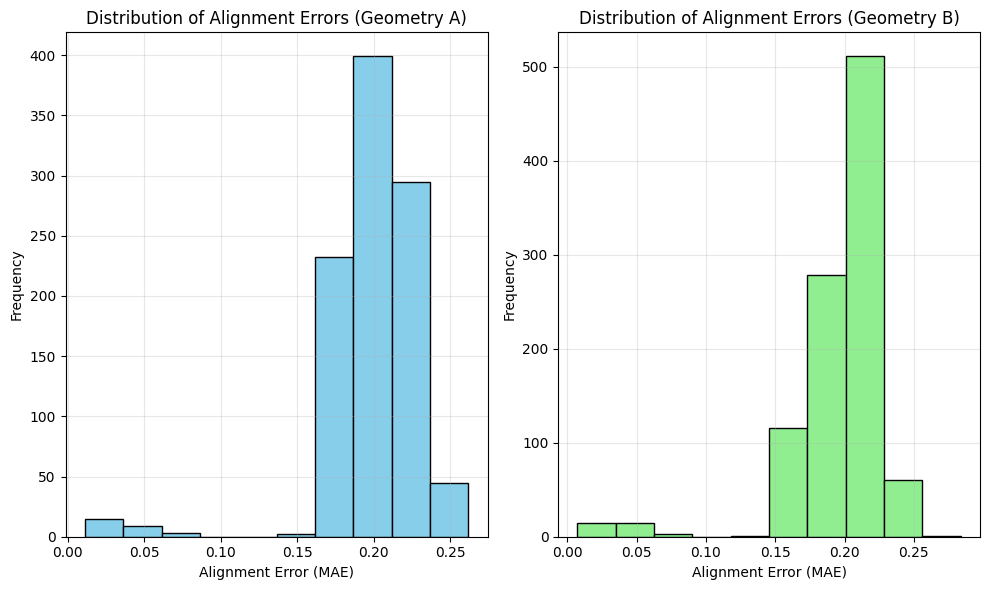

In [67]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# First subplot for errors_a
ax1.hist(errors_a, bins=10, color='skyblue', edgecolor='black')
ax1.set_xlabel('Alignment Error (MAE)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Alignment Errors (Geometry A)')
ax1.grid(True, alpha=0.3)

# Second subplot for errors_b
ax2.hist(errors_b, bins=10, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Alignment Error (MAE)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Alignment Errors (Geometry B)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [71]:
# Count the number of entries in errors_a with alignment error < 0.1
sum([error < 0.1 for error in errors_b])

Array(33, dtype=int64, weak_type=True)